# Multioutput Regressor
This notebook will explore to combine the 4 outputs required {batter_runs, strike_rate, final_team_total, nrr (win margin)}. We will explore a couple of methods
- 4 Models for the 4 outputs - Relation between outputs ignored 
- Chaining Models - Error Propagation 
- NN with 4 outputs - Lack of data, complexity

Challenges: Choosing a test set

In [25]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../../Data/selected_data/processed_data_NRR_with_venues.csv')

# merging medium bowlers to fast
data.loc[data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
data.loc[data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'
data['date'] = data['match_id'].apply(lambda x: x[-10: ])
data['date'] = pd.to_datetime(data['date'])

# Remove zimbabwe, ireland and Bangladesh
data = data[(data['bowling_team'] != 'Zimbabwe') & (data['batting_team'] != 'Zimbabwe')]
data = data[(data['bowling_team'] != 'Bangladesh') & (data['batting_team'] != 'Bangladesh')]
data = data[(data['bowling_team'] != 'Ireland') & (data['batting_team'] != 'Ireland')]


data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155321 entries, 0 to 215251
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   batter               155321 non-null  object        
 1   bowler               155321 non-null  object        
 2   non_striker          155321 non-null  object        
 3   runs_by_bat          155321 non-null  int64         
 4   extra_runs           155321 non-null  int64         
 5   total_runs_delivery  155321 non-null  int64         
 6   current_team_total   155321 non-null  int64         
 7   runs_remain          155321 non-null  float64       
 8   batter_runs          155321 non-null  int64         
 9   balls_faced          155321 non-null  int64         
 10  wickets_fallen       155321 non-null  int64         
 11  extra_type           155321 non-null  object        
 12  delivery             155321 non-null  float64       
 13  over               

In [56]:
data.loc[data['bowling_team'] == data['batting_team'], ['bowling_team', 'batting_team', 'match_id', 'batter', 'bowler']].count()

bowling_team    0
batting_team    0
match_id        0
batter          0
bowler          0
dtype: int64

In [10]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2]) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (
		    data['innings'].isin(innings))
	]

	player_data.head()

	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = ['date', 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over',
	    'delivery', 'wickets_fallen', 'bowling_team', 'batting_team', 'venue', 'toss_winner', 'runs_remain', 'net_run_rate', 'final_team_total']
	player_scores = gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery',
	                      'wickets_fallen', 'current_team_total']]
	first_ball['first_ball'] = (
	    first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']
	player_scores['current_team_total'] = first_ball['current_team_total']
	player_scores['is_powerplay'] = first_ball['first_ball'] <= 30

    # convert toss win to boolean
	player_scores['toss_winner'] = (
	    player_scores['toss_winner'] == player_scores['batting_team']).astype(int);

    # when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker']
	    == player_name].index

	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, [
	    'batter_runs', 'balls_faced']] = [0, 0]

	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (
	    player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]

	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)

	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(
	    player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (
	    player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)

	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs',
	    'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 +
	                          matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis=1)

	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]

		if player_data.empty:
			return player_data.drop('match_id', axis=1)

		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced

		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop(
		    'match_id', axis=1)  # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby(
	    'match_id')['bowler_type'].value_counts().unstack(fill_value=0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(
	    remaining_ball_types, how='left', on='match_id')

	player_scores.fillna(0, inplace=True)
	
    
    # if batsman ended as non_striker, make him the batter and drop the nonstriker column
	player_scores['batter'] = player_name
	player_scores.drop('non_striker', inplace=True, axis = 1)



	# Sort according to date
	player_scores.sort_values(by='date', inplace=True)

	def calculate_recent_form(row, window=30):
		"""
		Calculates the average runs scored by the player in the last 'window' days (excluding the current date).
		"""
		date = row['date']
		df = player_scores.copy()
		df = df[df['date'] < date]
		df = df[df['date'] >= (date - pd.Timedelta(days=window))]
		average_runs = df['batter_runs'].mean() if len(df) > 0 else 0
		return average_runs	

	player_scores['recent_form'] = player_scores.apply(calculate_recent_form, axis=1)
	
	# reindex
	player_scores.reset_index(drop=True, inplace=True)

	return player_scores

getPlayerScores('BKG Mendis').head()

C:\Users\kaush\AppData\Local\Temp\ipykernel_656\3874185176.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


,match_id,date,batter,batter_runs,balls_faced,wicket_type,won,innings,wickets_fallen,bowling_team,...,strike_rate,out,last_ball,Left arm Fast,Left arm Orthodox,Left arm Wrist spin,Right arm Fast,Right arm Legbreak,Right arm Offbreak,recent_form
0,England_Sri Lanka_2016-07-05,2016-07-05,BKG Mendis,21,16,caught and bowled,0.0,1,1,England,...,131.25,True,53,24,24,0,80,49,15,0.0
1,Sri Lanka_Australia_2016-09-06,2016-09-06,BKG Mendis,22,13,caught,0.0,2,3,Australia,...,169.23,True,47,34,24,0,74,25,34,0.0
2,Sri Lanka_Australia_2016-09-09,2016-09-09,BKG Mendis,5,7,lbw,0.0,1,3,Australia,...,71.43,True,53,31,11,0,33,37,35,22.0
3,South Africa_Sri Lanka_2017-01-20,2017-01-20,BKG Mendis,1,2,caught,0.0,2,4,South Africa,...,50.00,True,47,6,0,0,28,0,0,0.0
4,South Africa_Sri Lanka_2017-01-22,2017-01-22,BKG Mendis,4,2,bowled,1.0,2,1,South Africa,...,200.00,True,15,28,41,26,71,42,6,1.0


In [26]:
import warnings
warnings.filterwarnings('ignore')

# Generate merged_df by merging all batter scores together
merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    merged_df = pd.concat([merged_df, player_scores])


Analyzing Player AJ Finch
Analyzing Player M Klinger
Analyzing Player TM Head
Analyzing Player MC Henriques
Analyzing Player AJ Turner
Analyzing Player JP Faulkner
Analyzing Player N Dickwella
Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera
Analyzing Player DAS Gunaratne
Analyzing Player TAM Siriwardana
Analyzing Player CK Kapugedera
Analyzing Player S Prasanna
Analyzing Player BR Dunk
Analyzing Player TD Paine
Analyzing Player PJ Cummins
Analyzing Player AJ Tye
Analyzing Player JA Richardson
Analyzing Player BKG Mendis
Analyzing Player KMDN Kulasekara
Analyzing Player SL Malinga
Analyzing Player MD Shanaka
Analyzing Player JRMVB Sanjaya
Analyzing Player GD Phillips
Analyzing Player KS Williamson
Analyzing Player C Munro
Analyzing Player TC Bruce
Analyzing Player CJ Anderson
Analyzing Player C de Grandhomme
Analyzing Player L Ronchi
Analyzing Player MJ Santner
Analyzing Player BM Wheeler
Analyzing Player TG Southee
Analyzing Player TA Boult
Analyzing Player HM Amla
Analyzi

# Data Analysis to Seperate the test set

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10604 entries, 0 to 0
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   match_id             10604 non-null  object        
 1   date                 10604 non-null  datetime64[ns]
 2   batter               10604 non-null  object        
 3   batter_runs          10604 non-null  int64         
 4   balls_faced          10604 non-null  int64         
 5   wicket_type          10604 non-null  object        
 6   won                  10604 non-null  float64       
 7   innings              10604 non-null  int64         
 8   wickets_fallen       10604 non-null  int64         
 9   bowling_team         10604 non-null  object        
 10  batting_team         10604 non-null  object        
 11  venue                10604 non-null  object        
 12  toss_winner          10604 non-null  int32         
 13  runs_remain          10604 non-null  flo

In [28]:
# Drop all the records of lower order batsman (6 down and onwards)
merged_df = merged_df[merged_df['wickets_fallen'] < 6]

# Drop all the records of opening batsmen
merged_df = merged_df[merged_df['wickets_fallen'] != 0]

merged_df.loc[merged_df['balls_faced'] == 0, 'strike_rate'] = 0  # set SR to 0, if balls faced is 0

# Remove the columns that cannot be known by the ongoing match state
# Example: The out or wicket type is not known during the match
merged_df.drop(['wicket_type', 'out', 'won', 'balls_faced', 'last_ball', 'date'], axis = 1, inplace = True)

merged_df.reset_index(drop=True, inplace=True)

In [29]:
# merged_df.drop('Unnamed: 0', inplace=True, axis=1)

target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']



merged_df.to_csv('merged_df_checkpoint.csv')


merged_df[target_cols].describe()



,batter_runs,strike_rate,final_team_total,net_run_rate
count,5906.000000,5906.000000,5906.000000,5906.000000
mean,19.154419,113.427819,154.491873,-0.181961
std,19.065079,67.395880,34.501845,1.886555
min,0.000000,0.000000,45.000000,-8.400000
25%,5.000000,70.000000,133.000000,-1.028947
50%,13.000000,111.110000,155.000000,-0.133613
75%,28.000000,150.000000,177.000000,0.699668
max,120.000000,700.000000,267.000000,8.400000


In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5906 entries, 0 to 5905
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             5906 non-null   object 
 1   batter               5906 non-null   object 
 2   batter_runs          5906 non-null   int64  
 3   innings              5906 non-null   int64  
 4   wickets_fallen       5906 non-null   int64  
 5   bowling_team         5906 non-null   object 
 6   batting_team         5906 non-null   object 
 7   venue                5906 non-null   object 
 8   toss_winner          5906 non-null   int32  
 9   runs_remain          5906 non-null   float64
 10  net_run_rate         5906 non-null   float64
 11  final_team_total     5906 non-null   int64  
 12  first_ball           5906 non-null   int32  
 13  current_team_total   5906 non-null   int64  
 14  is_powerplay         5906 non-null   bool   
 15  strike_rate          5906 non-null   f

(0       2
1       3
2       2
3       3
4       2
       ..
5901    2
5902    2
5903    1
5904    0
5905    1
Name: batter_runs, Length: 5906, dtype: int64, array([  0.,   5.,  13.,  28., 120.]))


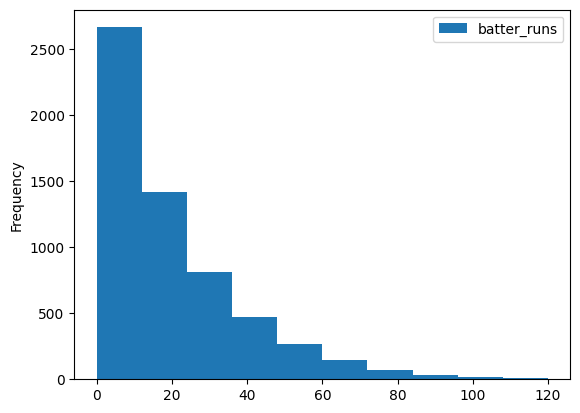

In [15]:
merged_df.plot.hist(column=['batter_runs'])
print(pd.qcut(merged_df['batter_runs'], 4, labels = False, retbins=True))

(0       2
 1       2
 2       3
 3       3
 4       3
        ..
 5901    0
 5902    3
 5903    1
 5904    0
 5905    0
 Name: net_run_rate, Length: 5906, dtype: int64,
 array([-8.4       , -1.02894737, -0.13361345,  0.69966814,  8.4       ]))

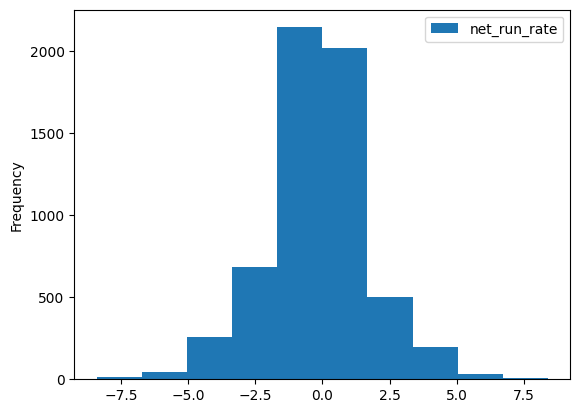

In [62]:
merged_df.plot.hist(column=['net_run_rate'])
pd.qcut(merged_df['net_run_rate'], 4, labels = False, retbins=True)

(0       1
1       1
2       0
3       2
4       0
       ..
5901    0
5902    0
5903    0
5904    0
5905    0
Name: final_team_total, Length: 5906, dtype: int64, array([ 45., 142., 168., 267.]))


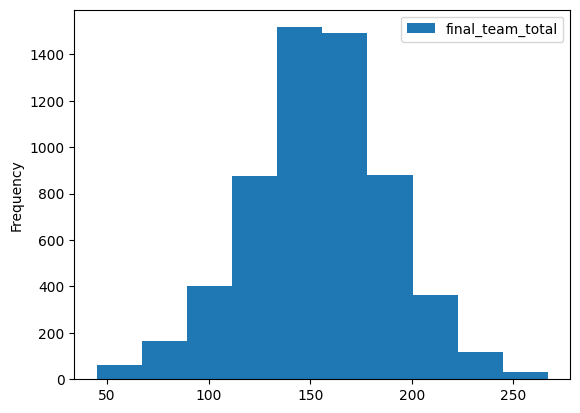

In [63]:
merged_df.plot.hist(column=['final_team_total'])
print(pd.qcut(merged_df['final_team_total'], 3, labels = False, retbins=True))

(0       1
1       2
2       2
3       2
4       2
       ..
5901    1
5902    2
5903    1
5904    0
5905    0
Name: strike_rate, Length: 5906, dtype: int64, array([  0.        ,  86.67      , 136.51333333, 700.        ]))


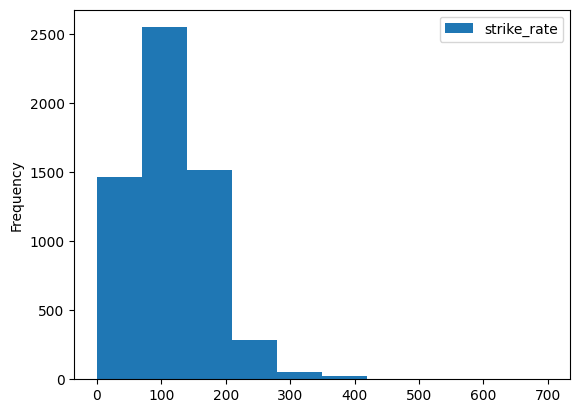

In [64]:
merged_df.plot.hist(column=['strike_rate'])
print(pd.qcut(merged_df['strike_rate'], 3, labels = False, retbins=True))

# Select matches (match_ids) from the original dataset, and separate them. 
Critieria: Date, Batting Team, Bowling Team

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit


matches = data.groupby('match_id').first().reset_index()

matches['split_cat'] = ( pd.to_datetime(matches['date']).dt.strftime('%Y') + "_" +
                             matches['batting_team'].astype(str) + "_" +
                             matches['bowling_team'].astype(str))

# Identify rare categories
value_counts = matches['split_cat'].value_counts()
rare_categories = value_counts[value_counts < 3].index

# Replace rare categories with 'other'
matches['split_cat'] = matches['split_cat'].apply(lambda x: 'other' if x in rare_categories else x)


# Split Train Test Data Sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(matches, matches['split_cat']):
    train_set_ids = matches.iloc[train_index]
    test_set_ids = matches.iloc[test_index]

train_set_ids = train_set_ids['match_id'].unique()
test_set_ids = test_set_ids['match_id'].unique()

In [60]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5906 entries, 0 to 5905
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             5906 non-null   object 
 1   batter               5906 non-null   object 
 2   batter_runs          5906 non-null   int64  
 3   innings              5906 non-null   int64  
 4   wickets_fallen       5906 non-null   int64  
 5   bowling_team         5906 non-null   object 
 6   batting_team         5906 non-null   object 
 7   venue                5906 non-null   object 
 8   toss_winner          5906 non-null   int32  
 9   runs_remain          5906 non-null   float64
 10  net_run_rate         5906 non-null   float64
 11  final_team_total     5906 non-null   int64  
 12  first_ball           5906 non-null   int32  
 13  current_team_total   5906 non-null   int64  
 14  is_powerplay         5906 non-null   bool   
 15  strike_rate          5906 non-null   f

In [61]:
train_set = merged_df[merged_df['match_id'].isin(train_set_ids)]
test_set = merged_df[merged_df['match_id'].isin(test_set_ids)]

print(test_set.info()) # 1185 
print(train_set.info()) # 4721 # 0.7933 of total data

train_set.drop('match_id', inplace=True, axis=1)
test_set.drop('match_id', inplace=True, axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 1185 entries, 12 to 5896
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             1185 non-null   object 
 1   batter               1185 non-null   object 
 2   batter_runs          1185 non-null   int64  
 3   innings              1185 non-null   int64  
 4   wickets_fallen       1185 non-null   int64  
 5   bowling_team         1185 non-null   object 
 6   batting_team         1185 non-null   object 
 7   venue                1185 non-null   object 
 8   toss_winner          1185 non-null   int32  
 9   runs_remain          1185 non-null   float64
 10  net_run_rate         1185 non-null   float64
 11  final_team_total     1185 non-null   int64  
 12  first_ball           1185 non-null   int32  
 13  current_team_total   1185 non-null   int64  
 14  is_powerplay         1185 non-null   bool   
 15  strike_rate          1185 non-null   float

(0       2
1       3
2       2
3       3
4       2
       ..
5901    2
5902    2
5903    1
5904    0
5905    1
Name: batter_runs, Length: 4721, dtype: int64, array([  0.,   5.,  13.,  27., 120.]))


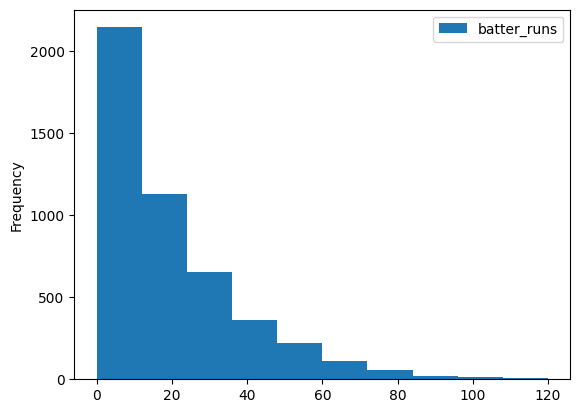

In [52]:
train_set.plot.hist(column=['batter_runs'])
print(pd.qcut(train_set['batter_runs'], 4, labels = False, retbins=True))


(0       1
1       2
2       2
3       2
4       2
       ..
5901    1
5902    2
5903    1
5904    0
5905    0
Name: strike_rate, Length: 4721, dtype: int64, array([  0.  ,  86.96, 136.36, 700.  ]))


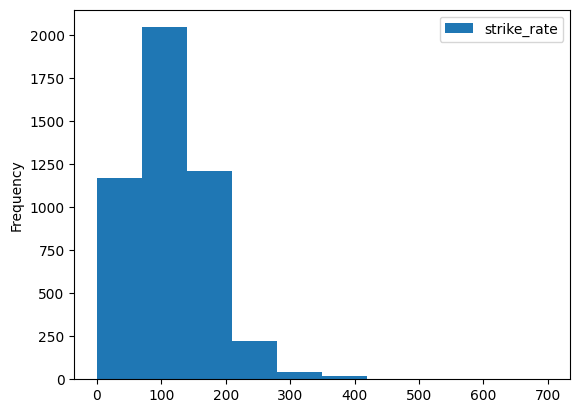

In [68]:
train_set.plot.hist(column=['strike_rate'])
print(pd.qcut(train_set['strike_rate'], 3, labels = False, retbins=True))


(0       1
1       1
2       0
3       2
4       0
       ..
5901    0
5902    0
5903    0
5904    0
5905    0
Name: final_team_total, Length: 4721, dtype: int64, array([ 45., 142., 168., 267.]))


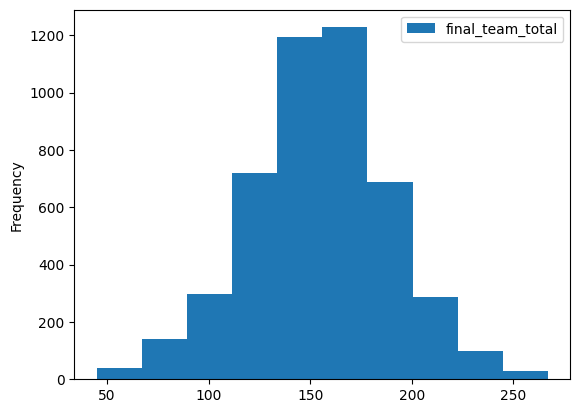

In [69]:
train_set.plot.hist(column=['final_team_total'])
print(pd.qcut(train_set['final_team_total'], 3, labels = False, retbins=True))


(0       2
1       2
2       3
3       3
4       3
       ..
5901    0
5902    3
5903    1
5904    0
5905    0
Name: net_run_rate, Length: 4721, dtype: int64, array([-8.4       , -1.1       , -0.15      ,  0.72142857,  8.4       ]))


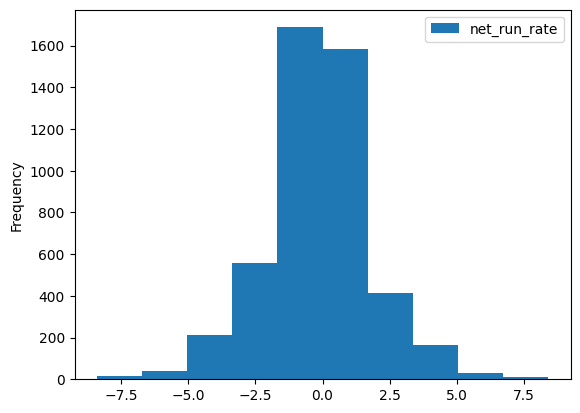

In [187]:
train_set.plot.hist(column=['net_run_rate'])
print(pd.qcut(train_set['net_run_rate'], 4, labels = False, retbins=True))


In [188]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedShuffleSplit

# # Create categorical variables for each target variable by binning
# merged_df['batter_runs_cat'] = pd.cut(merged_df['batter_runs'],
#                                       bins=[  -1.,   3.,  11.,  26., np.inf],
#                                       labels=['0-3', '3-11', '11-26', '26+'])

# merged_df['strike_rate_cat'] = pd.cut(merged_df['strike_rate'],
#                                       bins=[  -1.  ,  81.25, 133.33  , np.inf],
#                                       labels=['0-81.25', '81.25-133.33', '133.33+'])

# merged_df['final_team_total_cat'] = pd.cut(merged_df['final_team_total'],
#                                            bins=[ -1., 139., 166., np.inf],
#                                            labels=['0-139', '139-166', '166+'])

# merged_df['net_run_rate_cat'] = pd.cut(merged_df['net_run_rate'],
#                                        bins=[-np.inf, -1.23888889, -0.21949153,  0.6,  np.inf],
#                                        labels=['-1.24', '- 1.24 - -0.212', '-0.219 - 0.6', '0.6+'])

# # Combine categorical variables into a single variable
# merged_df['combined_cat'] = (merged_df['batter_runs_cat'].astype(str) + "_" +
#                              merged_df['strike_rate_cat'].astype(str) + "_" +
#                              merged_df['final_team_total_cat'].astype(str) + "_" +
#                              merged_df['net_run_rate_cat'].astype(str))



# merged_df['combined_cat'].unique()
# # merged_df.drop(['combined_cat', 'batter_runs_cat', 'strike_rate_cat', 'net_run_rate_cat', 'final_team_total_cat'], inplace=True, axis=1)


In [189]:
# # Identify rare categories
# value_counts = merged_df['combined_cat'].value_counts()
# rare_categories = value_counts[value_counts < 2].index

# # Replace rare categories with 'other'
# merged_df['combined_cat'] = merged_df['combined_cat'].apply(lambda x: 'other' if x in rare_categories else x)

# merged_df['combined_cat'].value_counts()

In [190]:
# from sklearn.model_selection import StratifiedShuffleSplit

# # Split Train Test Data Sets
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(merged_df, merged_df['combined_cat']):
#     train_set = merged_df.loc[train_index]
#     test_set = merged_df.loc[test_index]

# print("Test Set Value Counts:\n")
# print(test_set['batter_runs_cat'].value_counts() / len(test_set));
# print(test_set['strike_rate_cat'].value_counts() / len(test_set));
# print(test_set['final_team_total_cat'].value_counts() / len(test_set));
# print(test_set['net_run_rate_cat'].value_counts() / len(test_set));


# print("Train Set Value Counts:\n")
# print(train_set['batter_runs_cat'].value_counts() / len(train_set));
# print(train_set['strike_rate_cat'].value_counts() / len(train_set));
# print(train_set['final_team_total_cat'].value_counts() / len(train_set));
# print(train_set['net_run_rate_cat'].value_counts() / len(train_set));
# # Drop the categorical columns used for stratification
# for set_ in (train_set, test_set):
#     set_.drop(['batter_runs_cat', 'strike_rate_cat', 'final_team_total_cat', 'net_run_rate_cat', 'combined_cat'], axis=1, inplace=True)


# Prepare data for regression, feature engineering

## Venue Data Generation
Use the training set matches to generate information about the venues

In [62]:
# run first cell to generate data
gp = data[data['innings'] == 2].groupby('match_id')
gp = gp.last().reset_index();

#### REMOVE THE MATCHES IN THE TESTING SET
gp = gp[gp['match_id'].isin(train_set_ids)]

gp['first_innings_total'] = gp['final_team_total'] + gp['runs_remain'];
gp['second_innings_total'] = gp['final_team_total'];
gp.drop('final_team_total', inplace=True, axis=1);

venues_df = gp[['match_id', 'first_innings_total', 'second_innings_total', 'venue', 'won', 'host']]
venues_df.head()

,match_id,first_innings_total,second_innings_total,venue,won,host
0,Afghanistan_England_2022-10-22,112.0,113,Perth Stadium,1.0,Australia
1,Afghanistan_India_2024-01-11,158.0,159,Punjab Cricket Association IS Bindra Stadium,1.0,India
2,Afghanistan_India_2024-01-14,172.0,173,Holkar Cricket Stadium,1.0,India
3,Afghanistan_New Zealand_2021-11-07,124.0,125,Zayed Cricket Stadium,1.0,UAE
4,Afghanistan_Pakistan_2021-10-29,147.0,148,Dubai International Cricket Stadium,1.0,UAE


In [63]:
#Change "won" value mapping, bat first won = True
won_mapping = {-1: None, 0: True, 1: False}
venues_df['won'] = venues_df['won'].map(won_mapping)

# venues_df['first_bat_won'] = venues_df['won'].map({-1: False, 0: None, 1:True})
venues_df.head()

,match_id,first_innings_total,second_innings_total,venue,won,host
0,Afghanistan_England_2022-10-22,112.0,113,Perth Stadium,False,Australia
1,Afghanistan_India_2024-01-11,158.0,159,Punjab Cricket Association IS Bindra Stadium,False,India
2,Afghanistan_India_2024-01-14,172.0,173,Holkar Cricket Stadium,False,India
3,Afghanistan_New Zealand_2021-11-07,124.0,125,Zayed Cricket Stadium,False,UAE
4,Afghanistan_Pakistan_2021-10-29,147.0,148,Dubai International Cricket Stadium,False,UAE


In [64]:
gp = venues_df.groupby('venue')
total_mean = gp['first_innings_total'].mean()
total_std = gp['first_innings_total'].std()

first_bat_won_ratio = gp['won'].mean()
number_of_matches = gp.size()
host = gp.last()['host']

df = pd.DataFrame()
df['total_mean'] = total_mean
df['total_std'] = total_std
df['first_bat_won_ratio'] = first_bat_won_ratio
df['number_of_matches'] = number_of_matches
df['host'] = host


df.reset_index(inplace=True)
df.to_csv("train_venues.csv", index=False)
df.head(20)

,venue,total_mean,total_std,first_bat_won_ratio,number_of_matches,host
0,AMI Stadium,198.500000,21.920310,1.0,2,New Zealand
1,Adelaide Oval,188.250000,37.286056,0.75,4,Australia
2,Arun Jaitley Stadium,164.333333,41.404509,0.666667,3,India
3,Barabati Stadium,120.000000,39.597980,0.0,2,India
4,Barsapara Cricket Stadium,177.500000,84.145707,0.5,2,India
5,Bay Oval,178.333333,14.189198,1.0,3,New Zealand
6,Bellerive Oval,193.666667,33.486316,0.666667,3,Australia
7,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,172.200000,23.466998,1.0,5,India
8,Brabourne Stadium,166.000000,NaN,0.0,1,India
9,Brian Lara Stadium,184.500000,60.147042,0.75,4,West Indies


### Append the venues data to the train_set & the test set

In [65]:
import pandas as pd
import numpy as np

venues_df = pd.read_csv("train_venues.csv")
venues_df.info()


train_set = pd.merge(train_set, venues_df, how="left", on="venue").drop(['total_std', 'number_of_matches',], axis=1)
test_set = pd.merge(test_set, venues_df, how="left", on="venue").drop(['total_std', 'number_of_matches',], axis=1)


train_set['is_host'] = train_set['host'] == train_set['batting_team']
test_set['is_host'] = test_set['host'] == test_set['batting_team']

# drop venue column
train_set.drop(['venue', 'host'], axis = 1, inplace = True)
test_set.drop(['venue', 'host'], axis = 1, inplace = True)

train_set.rename(columns={"total_mean": "venue_mean_total", "first_bat_won_ratio": "venue_first_bat_won_ratio"}, inplace=True)
test_set.rename(columns={"total_mean": "venue_mean_total", "first_bat_won_ratio": "venue_first_bat_won_ratio"}, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   venue                88 non-null     object 
 1   total_mean           88 non-null     float64
 2   total_std            77 non-null     float64
 3   first_bat_won_ratio  88 non-null     float64
 4   number_of_matches    88 non-null     int64  
 5   host                 88 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 4.3+ KB


In [66]:
train_set['venue_mean_total'].median()
train_set['venue_first_bat_won_ratio'].median()

0.5

In [67]:
test_set.loc[test_set['venue_mean_total'].isna(), ['venue_mean_total', 'venue_first_bat_ratio']] = train_set['venue_mean_total'].median(), train_set['venue_first_bat_won_ratio'].median()

Checking for empty values. i.e venue not in training data.
No worries here rn, but might be a problem later for new datasets

### Runs Remaining Feature for Innings 1 (Estimation)

In [68]:
def get_runs_remain(innings, venue_mean_total, current_team_total, runs_remain):
    if innings == 2:
        return runs_remain
    return int(venue_mean_total - current_team_total)

# replace the -1 of the first innings with the venue_average - current total
train_set['runs_remain'] = train_set[['innings', 'venue_mean_total', 'current_team_total', 'runs_remain']].apply(
    lambda x: get_runs_remain(*x)
, axis = 1)

test_set['runs_remain'] = test_set[['innings', 'venue_mean_total', 'current_team_total', 'runs_remain']].apply(
    lambda x: get_runs_remain(*x)
, axis = 1)

## Batter Bowler Type Features

In [70]:
def get_player_v_bowlers(player_name: str, match_ids, innings=[1, 2], ) -> pd.DataFrame:
    player_data = data.loc[
        (data['batter'] == player_name) & (data['innings'].isin(
            innings)) & (data['match_id'].isin(match_ids))
    ]

    player_data.head()

    # Convert all medium bowlers to fast
    player_data.loc[player_data['bowler_type'] ==
                    'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
    player_data.loc[player_data['bowler_type'] ==
                    'Right arm Medium', 'bowler_type'] = 'Right arm Fast'

    player_data['out'] = (player_data['wicket_type'] != '0') & (
        player_data['wicket_type'] != 'run out')

    cols = ['batter', 'non_striker', 'runs_by_bat', 'out',
            'won', 'innings', 'over', 'delivery', 'bowler_type']
    player_data = player_data[cols]

    gp = player_data.groupby('bowler_type')

    player_v_bowler = pd.DataFrame()
    player_v_bowler['strike_rate'] = round(gp['runs_by_bat'].mean() * 100, 3)
    player_v_bowler['strike_rate_std'] = gp['runs_by_bat'].std()
    player_v_bowler['wickets'] = gp['out'].sum()
    player_v_bowler['deliveries_per_wicket'] = round(1 / gp['out'].mean(), 3)
    player_v_bowler['deliveries'] = gp.size()
    return player_v_bowler


def attach_bowler_type_stats(player_scores):
    
    player_name = player_scores['batter'].iloc[0]
    player_vs_bowler = get_player_v_bowlers(player_name, match_ids = train_set_ids);
    
    bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox',
                    'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
    for bowler_type in bowler_types:
        if bowler_type in player_vs_bowler.index:
            player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type,
                                                                                 'strike_rate'] / 100 * player_scores[bowler_type]
            player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / \
                player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
            player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = player_vs_bowler.loc[bowler_type,
                                                                                     'deliveries_per_wicket']
        else:
            player_scores[bowler_type] = 0
            player_scores[f'{bowler_type} Expected Runs'] = 0
            player_scores[f'{bowler_type} Expected Wickets'] = 0
            player_scores[f'{bowler_type} Strike Rate'] = 0
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0
            
    return player_scores

# Appending bowler type data to the training set   
gp = train_set.groupby('batter')
result = gp.apply(attach_bowler_type_stats);

train_set = result.reset_index(drop=True)

# Appending the bowler type data to the testing set -> Only the training summaries are used (test set averages, strikerates are not used)
gp = test_set.groupby('batter')
result = gp.apply(attach_bowler_type_stats);
test_set = result.reset_index(drop=True)



In [71]:
import warnings
warnings.filterwarnings('ignore')

# Generate merged_df by merging all batter scores together
player_vs_bowler_types_merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    df = get_player_v_bowlers(player, train_set_ids)
    df['batter'] = player
    df.reset_index(inplace=True)
    player_vs_bowler_types_merged_df = pd.concat([player_vs_bowler_types_merged_df, df])


player_vs_bowler_types_merged_df.to_csv('train_player_vs_bowler.csv', index=False)

Analyzing Player AJ Finch
Analyzing Player M Klinger
Analyzing Player TM Head
Analyzing Player MC Henriques
Analyzing Player AJ Turner
Analyzing Player JP Faulkner
Analyzing Player N Dickwella
Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera
Analyzing Player DAS Gunaratne
Analyzing Player TAM Siriwardana
Analyzing Player CK Kapugedera
Analyzing Player S Prasanna
Analyzing Player BR Dunk
Analyzing Player TD Paine
Analyzing Player PJ Cummins
Analyzing Player AJ Tye
Analyzing Player JA Richardson
Analyzing Player BKG Mendis
Analyzing Player KMDN Kulasekara
Analyzing Player SL Malinga
Analyzing Player MD Shanaka
Analyzing Player JRMVB Sanjaya
Analyzing Player GD Phillips
Analyzing Player KS Williamson
Analyzing Player C Munro
Analyzing Player TC Bruce
Analyzing Player CJ Anderson
Analyzing Player C de Grandhomme
Analyzing Player L Ronchi
Analyzing Player MJ Santner
Analyzing Player BM Wheeler
Analyzing Player TG Southee
Analyzing Player TA Boult
Analyzing Player HM Amla
Analyzi

In [73]:
# Additional Features Experimenting

bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
bowler_types_expected_wickets_cols = [bowler_type + " Expected Wickets" for bowler_type in bowler_types]
bowler_types_expected_runs_cols = [bowler_type + " Expected Runs" for bowler_type in bowler_types]

train_set['expected_wickets'] = train_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
train_set['expected_runs'] = train_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
train_set['expected_runs'] = train_set['expected_runs'] / np.sqrt(train_set['expected_wickets']) 

test_set['expected_wickets'] = test_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
test_set['expected_runs'] = test_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
test_set['expected_runs'] = test_set['expected_runs'] / np.sqrt(test_set['expected_wickets'])


print(train_set.loc[:, ['batter_runs', 'expected_runs']].corr())

               batter_runs  expected_runs
batter_runs       1.000000       0.422957
expected_runs     0.422957       1.000000


# Encoding the data

In [74]:
# fill 0 for NaN
test_set.fillna(value=0, inplace=True)
train_set.fillna(value=0, inplace=True)

# Replace infinity values by a high constant value
# These occured at deliveries per wicket column
# So infinity can be thought as the batsman never getting out
# i.e 120 balls faced, hence replacing inf with 120
train_set.replace([np.inf], 120, inplace=True);
test_set.replace([np.inf], 120, inplace=True);



In [75]:
train_set.describe()

,batter_runs,innings,wickets_fallen,toss_winner,runs_remain,net_run_rate,final_team_total,first_ball,current_team_total,strike_rate,...,Right arm Legbreak Expected Runs,Right arm Legbreak Expected Wickets,Right arm Legbreak Strike Rate,Right arm Legbreak Deliveries Per Wicket,Right arm Offbreak Expected Runs,Right arm Offbreak Expected Wickets,Right arm Offbreak Strike Rate,Right arm Offbreak Deliveries Per Wicket,expected_wickets,expected_runs
count,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,...,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000
mean,19.037492,1.472358,2.855751,0.498623,75.311587,-0.182466,154.736920,54.233213,71.673586,113.353802,...,17.532613,0.883696,113.005044,37.334861,18.216111,0.790790,112.663791,41.483002,6.790343,60.721715
std,19.020597,0.499288,1.393445,0.500051,53.587151,1.934009,34.345075,32.542008,50.047452,67.482318,...,20.914694,1.834271,43.021702,38.676762,21.924721,1.942991,45.509876,39.052626,6.267744,27.701873
min,0.000000,1.000000,1.000000,0.000000,-81.000000,-8.400000,45.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1.000000,2.000000,0.000000,32.000000,-1.100000,133.000000,25.000000,29.000000,70.000000,...,0.000000,0.000000,94.175000,13.429000,0.000000,0.000000,93.182000,15.857000,3.574963,41.270899
50%,13.000000,1.000000,3.000000,0.000000,76.000000,-0.150000,155.000000,53.000000,66.000000,111.760000,...,9.658560,0.246914,109.890000,20.250000,10.250020,0.220339,112.903000,24.333000,5.891826,59.541517
75%,27.000000,2.000000,4.000000,1.000000,118.000000,0.721429,176.000000,81.000000,106.000000,150.000000,...,29.072100,1.142857,138.298000,43.400000,29.133270,1.011236,134.783000,50.750000,8.546436,78.713513
max,120.000000,2.000000,5.000000,1.000000,267.000000,8.400000,267.000000,120.000000,259.000000,700.000000,...,135.014680,46.000000,400.000000,120.000000,154.000140,64.000000,314.286000,120.000000,167.000000,320.134536


In [76]:
# Saving checkpoint
train_set.to_csv("train_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

### Separating Target and Input

In [1]:
import pandas as pd

test_set = pd.read_csv("test_set.csv")
train_set = pd.read_csv("train_set.csv")

# Seperate target and input
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']
X = train_set.drop(target_cols, axis=1)
y = train_set[target_cols]

# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()

# X_processed = encoder.fit_transform(X)

X_processed = pd.get_dummies(data=X,dtype=int)

In [29]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721 entries, 0 to 4720
Columns: 490 entries, innings to batting_team_West Indies
dtypes: bool(2), float64(36), int32(447), int64(5)
memory usage: 9.5 MB


In [30]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721 entries, 0 to 4720
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   batter_runs       4721 non-null   int64  
 1   strike_rate       4721 non-null   float64
 2   final_team_total  4721 non-null   int64  
 3   net_run_rate      4721 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 147.7 KB


In [81]:
X.columns

Index(['batter', 'innings', 'wickets_fallen', 'bowling_team', 'batting_team',
       'toss_winner', 'runs_remain', 'first_ball', 'current_team_total',
       'is_powerplay', 'Left arm Fast', 'Left arm Orthodox',
       'Left arm Wrist spin', 'Right arm Fast', 'Right arm Legbreak',
       'Right arm Offbreak', 'recent_form', 'venue_mean_total',
       'venue_first_bat_won_ratio', 'is_host', 'Left arm Fast Expected Runs',
       'Left arm Fast Expected Wickets', 'Left arm Fast Strike Rate',
       'Left arm Fast Deliveries Per Wicket', 'Right arm Fast Expected Runs',
       'Right arm Fast Expected Wickets', 'Right arm Fast Strike Rate',
       'Right arm Fast Deliveries Per Wicket',
       'Left arm Orthodox Expected Runs', 'Left arm Orthodox Expected Wickets',
       'Left arm Orthodox Strike Rate',
       'Left arm Orthodox Deliveries Per Wicket',
       'Left arm Wrist spin Expected Runs',
       'Left arm Wrist spin Expected Wickets',
       'Left arm Wrist spin Strike Rate',
      

In [82]:
X.loc[0, :]

batter                                       A Flintoff
innings                                               1
wickets_fallen                                        1
bowling_team                                  Australia
batting_team                                    England
toss_winner                                           1
runs_remain                                       139.0
first_ball                                           24
current_team_total                                   29
is_powerplay                                       True
Left arm Fast                                       0.0
Left arm Orthodox                                  18.0
Left arm Wrist spin                                 0.0
Right arm Fast                                    146.0
Right arm Legbreak                                  0.0
Right arm Offbreak                                  0.0
recent_form                                         0.0
venue_mean_total                             168

# ML Models

### Stratification for Validation

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Create categorical variables for each target variable by binning
y['batter_runs_cat'] = pd.cut(y['batter_runs'],
                                      bins=[-1.,   3.,  11.,  26., np.inf],
                                      labels=['0-3', '3-11', '11-26', '26+'])

y['strike_rate_cat'] = pd.cut(y['strike_rate'],
                                      bins=[-1  ,  81.25, 134.29, np.inf],
                                      labels=['0-81.25', '81.25-134.29', '134.29+'])

y['final_team_total_cat'] = pd.cut(y['final_team_total'],
                                           bins=[-1., 139., 166., np.inf],
                                           labels=['0-139', '139-166', '166+'])

y['net_run_rate_cat'] = pd.cut(y['net_run_rate'],
                                       bins=[-np.inf      , -1.25      , -0.21737288,  0.64473684,  np.inf    ],
                                       labels=['-1.25', '-1.25 - -0.217', '-0.217 - 0.64', '0.64+'])

# Combine categorical variables into a single variable
y['combined_cat'] = (y['batter_runs_cat'].astype(str) + "_" +
                             y['strike_rate_cat'].astype(str) + "_" +
                             y['final_team_total_cat'].astype(str) + "_" +
                             y['net_run_rate_cat'].astype(str))

# Identify rare categories
value_counts = y['combined_cat'].value_counts()
rare_categories = value_counts[value_counts < 2].index

# Replace rare categories with 'other'
y['combined_cat'] = y['combined_cat'].apply(lambda x: 'other' if x in rare_categories else x)

# Initialize StratifiedKFold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# Split the dataset
iterations = []
for train_index, test_index in skf.split(X_processed, y['combined_cat']):
    X_train = X_processed.iloc[train_index]
    X_valid = X_processed.iloc[test_index]
    y_train = y.iloc[train_index].drop(['batter_runs_cat', 'strike_rate_cat', 'final_team_total_cat', 'net_run_rate_cat', 'combined_cat'], axis=1)
    y_valid = y.iloc[test_index].drop(['batter_runs_cat', 'strike_rate_cat', 'final_team_total_cat', 'net_run_rate_cat', 'combined_cat'], axis=1)
    
    iterations.append((X_train, X_valid, y_train, y_valid))

# Accessing the first fold
X_train, X_valid, y_train, y_valid = iterations[0]

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (4248, 490)
X_valid shape: (473, 490)
y_train shape: (4248, 4)
y_valid shape: (473, 4)


C:\Users\kaush\AppData\Local\Temp\ipykernel_656\1215654382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['batter_runs_cat'] = pd.cut(y['batter_runs'],
C:\Users\kaush\AppData\Local\Temp\ipykernel_656\1215654382.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['strike_rate_cat'] = pd.cut(y['strike_rate'],
C:\Users\kaush\AppData\Local\Temp\ipykernel_656\1215654382.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [129]:
y_train

,batter_runs,strike_rate,final_team_total,net_run_rate
1,0,0.00,144,-3.850000
2,1,100.00,159,-0.250000
3,8,200.00,200,-0.900000
4,32,246.15,214,2.200000
5,0,0.00,79,-5.000000
...,...,...,...,...
4716,4,80.00,79,-2.350000
4717,24,104.35,119,0.960234
4718,21,116.67,161,0.400000
4719,12,92.31,147,-0.796789


## Approach 1: Neural Network with 4 outputs

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each iteration
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Define the model architecture using the Functional API
    inputs = keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Define multiple output layers
    outputs = [layers.Dense(1, name=col)(x) for col in target_cols]
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Define loss functions for different outputs
    losses = {col: "mean_squared_error" for col in target_cols}
    loss_weights = {col: 1.0 for col in target_cols}

    # Compile the model with multiple loss functions
    model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights)

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model
    history = model.fit(
        X_train_scaled, 
        {col: y_train[col] for col in target_cols},
        epochs=100,
        validation_data=(X_valid_scaled, {col: y_valid[col] for col in target_cols}),
        callbacks=[early_stopping],
        verbose=0
    )

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[i])
        iteration_results[col].append(mse)

    # Clear the session to free up memory
    tf.keras.backend.clear_session()

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing iteration 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Processing iteration 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing iteration 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing iteration 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing iteration 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing iteration 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing iteration 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing iteration 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing iteration 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing iteration 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
batter_runs:
  Mean MSE: 298.0397
  Std Dev MSE: 23.4146

strike_rate:
  Mean MSE: 4260.3285
  Std Dev MSE: 394.8569

final_team_total:
  Mean MSE: 689.2336
  Std Dev MSE: 70.1115

net_run_rate:
  Mean MSE: 4.1213
  Std Dev MSE: 0.3445



## Approach 2: Multioutput Regressor using Gradboost

In [19]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Create and train the MultiOutputRegressor with GradientBoostingRegressor
    base_estimator = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model = MultiOutputRegressor(base_estimator)
    
    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing fold 1/10
Processing fold 2/10
Processing fold 3/10
Processing fold 4/10
Processing fold 5/10
Processing fold 6/10
Processing fold 7/10
Processing fold 8/10
Processing fold 9/10
Processing fold 10/10
batter_runs:
  Mean MSE: 229.2044
  Std Dev MSE: 24.6602

strike_rate:
  Mean MSE: 3941.8135
  Std Dev MSE: 347.1669

final_team_total:
  Mean MSE: 411.8926
  Std Dev MSE: 27.8940

net_run_rate:
  Mean MSE: 2.1159
  Std Dev MSE: 0.1827



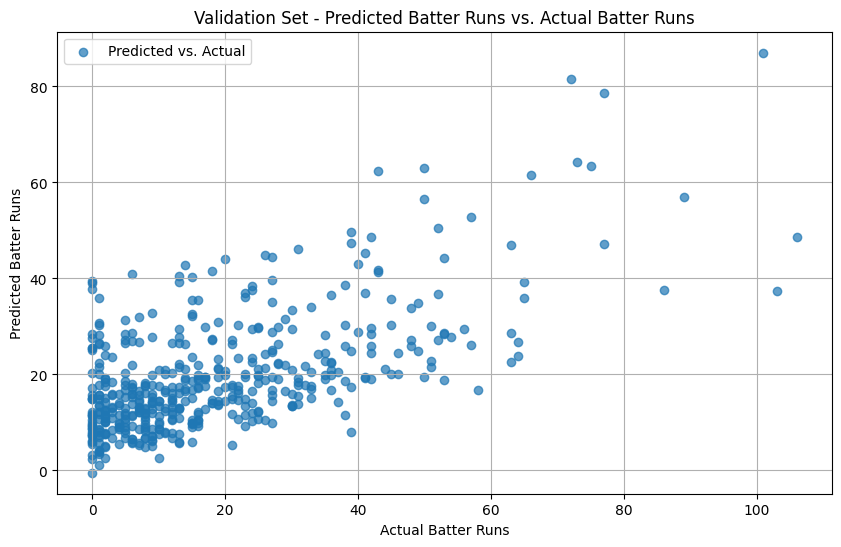

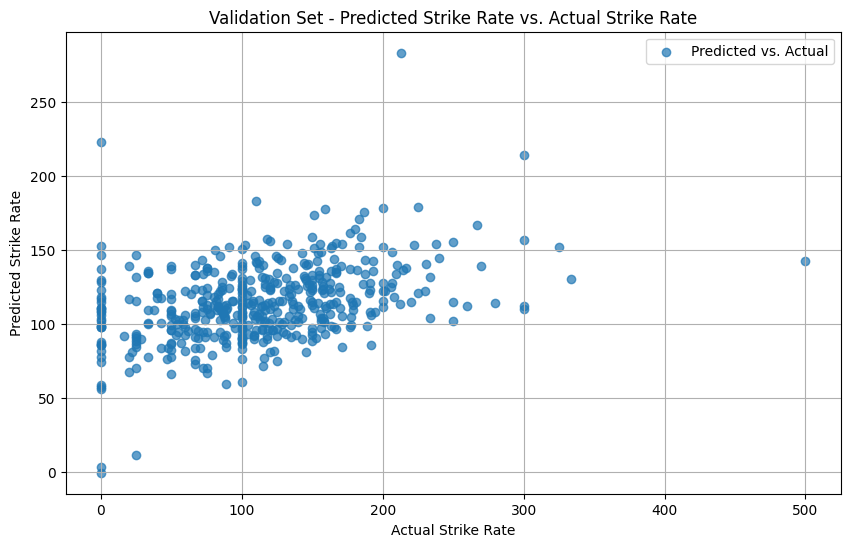

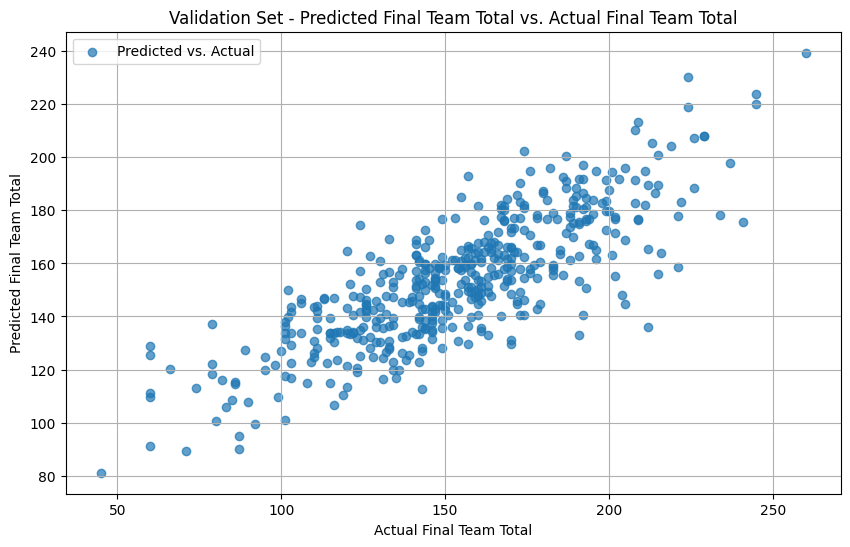

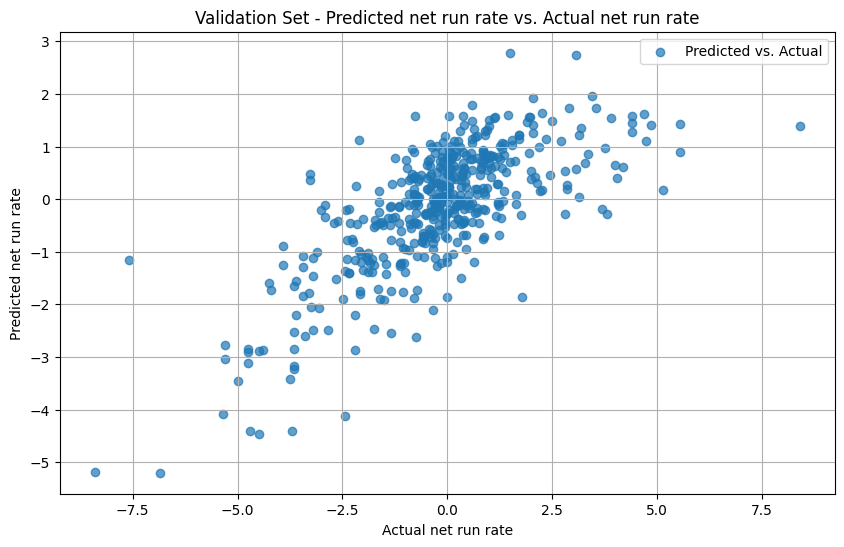

In [32]:
y_pred = model.predict(X_valid_scaled)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_valid['batter_runs'], y_pred[:, 0], alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Batter Runs')
plt.ylabel('Predicted Batter Runs')
plt.title('Validation Set - Predicted Batter Runs vs. Actual Batter Runs')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_valid['strike_rate'], y_pred[:, 1], alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Strike Rate')
plt.ylabel('Predicted Strike Rate')
plt.title('Validation Set - Predicted Strike Rate vs. Actual Strike Rate')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_valid['final_team_total'], y_pred[:,2], alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Final Team Total')
plt.ylabel('Predicted Final Team Total')
plt.title('Validation Set - Predicted Final Team Total vs. Actual Final Team Total')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 6))
plt.scatter(y_valid['net_run_rate'], y_pred[:,3], alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual net run rate')
plt.ylabel('Predicted net run rate')
plt.title('Validation Set - Predicted net run rate vs. Actual net run rate')
plt.legend()
plt.grid(True)
plt.show()


From the observations and the errors, multioutput regressor performs the best. This creates different indpendant models for each output variable. We will explore models, and hyperparameter tuning for the this approach

## Approach 3: Chanined Regressor using Gradboost

In [18]:
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables in the desired order
target_cols = ['final_team_total', 'net_run_rate', 'strike_rate', 'batter_runs']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Ensure y_train and y_valid contain only the target columns in the correct order
    y_train_ordered = y_train[target_cols]
    y_valid_ordered = y_valid[target_cols]
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Create and train the RegressorChain with GradientBoostingRegressor
    base_estimator = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model = RegressorChain(base_estimator, order=range(len(target_cols)), random_state=42)
    
    # Fit the model
    model.fit(X_train_scaled, y_train_ordered)

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid_ordered[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing fold 1/10
Processing fold 2/10
Processing fold 3/10
Processing fold 4/10
Processing fold 5/10
Processing fold 6/10
Processing fold 7/10
Processing fold 8/10
Processing fold 9/10
Processing fold 10/10
final_team_total:
  Mean MSE: 411.8926
  Std Dev MSE: 27.8940

net_run_rate:
  Mean MSE: 2.1523
  Std Dev MSE: 0.1745

strike_rate:
  Mean MSE: 3965.7999
  Std Dev MSE: 351.1257

batter_runs:
  Mean MSE: 245.1919
  Std Dev MSE: 17.9149



 # Finalized Approach : Multioutput Regressor
 Explore more models, and tune hyperparameters using grid search

#### Gradient Boosing Regressor

In [13]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Create and train the MultiOutputRegressor with GradientBoostingRegressor
    base_estimator = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model = MultiOutputRegressor(base_estimator)
    
    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing iteration 1/10
Processing iteration 2/10


KeyboardInterrupt: 

#### RandomForest Regressor

In [33]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Create and train the MultiOutputRegressor with RandomForestRegressor
    base_estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    model = MultiOutputRegressor(base_estimator)
    
    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing fold 1/10
Processing fold 2/10
Processing fold 3/10
Processing fold 4/10
Processing fold 5/10
Processing fold 6/10
Processing fold 7/10
Processing fold 8/10
Processing fold 9/10
Processing fold 10/10
batter_runs:
  Mean MSE: 237.4079
  Std Dev MSE: 23.3582

strike_rate:
  Mean MSE: 4092.1328
  Std Dev MSE: 363.2284

final_team_total:
  Mean MSE: 404.4878
  Std Dev MSE: 26.0535

net_run_rate:
  Mean MSE: 1.9898
  Std Dev MSE: 0.1694



#### XGBoost Regressor

In [14]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
    base_estimator = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model = MultiOutputRegressor(base_estimator)
    
    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing iteration 1/10
Processing iteration 2/10
Processing iteration 3/10
Processing iteration 4/10
Processing iteration 5/10
Processing iteration 6/10
Processing iteration 7/10
Processing iteration 8/10
Processing iteration 9/10
Processing iteration 10/10
batter_runs:
  Mean MSE: 260.9505
  Std Dev MSE: 29.5162

strike_rate:
  Mean MSE: 4454.4714
  Std Dev MSE: 302.1404

final_team_total:
  Mean MSE: 361.5944
  Std Dev MSE: 31.5159

net_run_rate:
  Mean MSE: 1.9074
  Std Dev MSE: 0.1513



#### SVM Regressor

In [5]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
    # base_estimator = xgb.XGBRegressor(n_estimators=100, random_state=42)
    base_estimator = SVR(kernel='rbf')
    model = MultiOutputRegressor(base_estimator)
    
    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing fold 1/10
Processing fold 2/10
Processing fold 3/10
Processing fold 4/10
Processing fold 5/10
Processing fold 6/10
Processing fold 7/10
Processing fold 8/10
Processing fold 9/10
Processing fold 10/10
batter_runs:
  Mean MSE: 337.2235
  Std Dev MSE: 24.3678

strike_rate:
  Mean MSE: 4443.6583
  Std Dev MSE: 402.2194

final_team_total:
  Mean MSE: 1005.7787
  Std Dev MSE: 49.5586

net_run_rate:
  Mean MSE: 2.8575
  Std Dev MSE: 0.1920



### Gradient Boosting for Batter Runs

In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

target_cols = ['batter_runs']

param_grid_gbr = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 4, 5, 6],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__subsample': [0.6, 0.8, 1.0]
}


  # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)


gbr = GradientBoostingRegressor(random_state=42, loss='absolute_error')
model = MultiOutputRegressor(gbr)

grid_search_gb = GridSearchCV(estimator=model, param_grid=param_grid_gbr, cv=3, n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train_scaled, y[target_cols])

best_params_xgb = grid_search_gb.best_params_

print("Best parameters for GBRegressor:", best_params_xgb)
model = grid_search_gb.best_estimator_
    
  

  

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()
    


## Perform GridSearch Search on All cols except batter runs   XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

target_cols = ['strike_rate', 'final_team_total', 'net_run_rate']


param_grid_xgb = {
    'estimator__n_estimators': [80, 100],
    'estimator__max_depth': [4, 5, 6],
    'estimator__learning_rate': [0.03, 0.05, 0.07],
    'estimator__subsample': [0.7, 0.8, 0.9],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9]
}


  # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
base_estimator = xgb.XGBRegressor()

model = MultiOutputRegressor(base_estimator)

grid_search_xgb = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train_scaled, y[target_cols])

best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBRegressor:", best_params_xgb)
model = grid_search_xgb.best_estimator_

    
  

  

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = [ 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

## Perform GridSearch Search on All cols   XGBoost

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']




param_grid_xgb = {
    'estimator__n_estimators': [80, 100],
    'estimator__max_depth': [4, 5, 6],
    'estimator__learning_rate': [0.03, 0.05, 0.07],
    'estimator__subsample': [0.7, 0.8, 0.9],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9]
}


  # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
base_estimator = xgb.XGBRegressor()

model = MultiOutputRegressor(base_estimator)

grid_search_xgb = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train_scaled, y[target_cols])

best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBRegressor:", best_params_xgb)
model = grid_search_xgb.best_estimator_

    
  

  

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for XGBRegressor: {'estimator__colsample_bytree': 0.9, 'estimator__learning_rate': 0.07, 'estimator__max_depth': 6, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}


In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Column names of the target variables
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']

# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    predictions = model.predict(X_valid_scaled)

    # Calculate MSE for each output
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_valid[col], predictions[:, i])
        iteration_results[col].append(mse)

# Calculate mean and standard deviation for each output
for col in target_cols:
    mean_mse = np.mean(iteration_results[col])
    std_mse = np.std(iteration_results[col])
    print(f"{col}:")
    print(f"  Mean MSE: {mean_mse:.4f}")
    print(f"  Std Dev MSE: {std_mse:.4f}")
    print()

Processing iteration 1/10
Processing iteration 2/10
Processing iteration 3/10
Processing iteration 4/10
Processing iteration 5/10
Processing iteration 6/10
Processing iteration 7/10
Processing iteration 8/10
Processing iteration 9/10
Processing iteration 10/10
batter_runs:
  Mean MSE: 231.6875
  Std Dev MSE: 26.2281

strike_rate:
  Mean MSE: 3967.8280
  Std Dev MSE: 340.2009

final_team_total:
  Mean MSE: 344.2961
  Std Dev MSE: 24.1851

net_run_rate:
  Mean MSE: 1.7536
  Std Dev MSE: 0.1319



## XGBOOST Separate Models for each output column

In [2]:
import pandas as pd

test_set = pd.read_csv("test_set.csv")

# Seperate target and input
target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']
X_test = test_set.drop(target_cols, axis=1)
y_test = test_set[target_cols]



X_processed_test = pd.get_dummies(data=X_test,dtype=int)
# scaler = StandardScaler()
# X_processed_test_scaled = scaler.fit_transform(X_processed_test)


In [3]:
import pandas as pd

train_columns = X_processed.columns.tolist()
test_columns = X_processed_test.columns.tolist()


missing_columns = set(train_columns) - set(test_columns)

for col in missing_columns:
    X_processed_test[col] = 0

test_encoded = X_processed_test.reindex(columns=train_columns, fill_value=0)

print(f"Train columns: {X_processed.shape}")
print(f"Test columns: {X_processed_test.shape}")


Train columns: (4721, 490)
Test columns: (1185, 510)


C:\Users\Mansitha Eashwara\AppData\Local\Temp\ipykernel_16476\3580938758.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_processed_test[col] = 0
C:\Users\Mansitha Eashwara\AppData\Local\Temp\ipykernel_16476\3580938758.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_processed_test[col] = 0
C:\Users\Mansitha Eashwara\AppData\Local\Temp\ipykernel_16476\3580938758.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [4]:
train_columns = X_processed.columns.tolist()
test_columns = X_processed_test.columns.tolist()


missing_columns = set(test_columns) - set(train_columns) 

for col in missing_columns:
    X_processed[col] = 0

test_encoded = X_processed.reindex(columns=test_columns, fill_value=0)

print(f"Train columns: {X_processed.shape}")
print(f"Test columns: {X_processed_test.shape}")

Train columns: (4721, 510)
Test columns: (1185, 510)


In [9]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721 entries, 0 to 4720
Columns: 490 entries, innings to batting_team_West Indies
dtypes: bool(2), float64(36), int32(447), int64(5)
memory usage: 9.5 MB


In [10]:
X_processed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Columns: 361 entries, innings to batting_team_West Indies
dtypes: bool(2), float64(37), int32(317), int64(5)
memory usage: 1.8 MB


### Batter Runs

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

target_cols = ['batter_runs']



param_grid_xgb = {
    'n_estimators': [80, 100],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


  # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
base_estimator = xgb.XGBRegressor()

grid_search_xgb = GridSearchCV(estimator=base_estimator, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train_scaled, y[target_cols])

best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBRegressor:", best_params_xgb)
model = grid_search_xgb.best_estimator_




from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np


# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])


    # Predict on validation set
    y_pred = model.predict(X_valid_scaled)
    mse = mean_squared_error(y_valid[col], y_pred)
    iteration_results.append(mse)

# Calculate mean and standard deviation for each output
mean_mse = np.mean(iteration_results)
std_mse = np.std(iteration_results)
print(f"{col}:")
print(f"  Mean MSE: {mean_mse:.4f}")
print(f"  Std Dev MSE: {std_mse:.4f}")
print()
  
  

  

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for XGBRegressor: {'estimator__colsample_bytree': 0.7, 'estimator__learning_rate': 0.07, 'estimator__max_depth': 4, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Processing iteration 1/10
Processing iteration 2/10
Processing iteration 3/10
Processing iteration 4/10
Processing iteration 5/10
Processing iteration 6/10
Processing iteration 7/10
Processing iteration 8/10
Processing iteration 9/10
Processing iteration 10/10
batter_runs:
  Mean MSE: 228.2750
  Std Dev MSE: 24.5762



### Batter Runs Test Set Performance

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
best_params_batter_runs = {'estimator__colsample_bytree': 0.7, 'estimator__learning_rate': 0.07, 'estimator__max_depth': 4, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)
X_test_scaled = scaler.fit_transform(X_processed_test)



model = xgb.XGBRegressor(**best_params_batter_runs)
model.fit(X_train_scaled,y["batter_runs"])

y_test_br_predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test["batter_runs"], y_test_br_predictions)
print(mse)

c:\Users\Mansitha Eashwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__n_estimators", "estimator__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


414.74497221578986


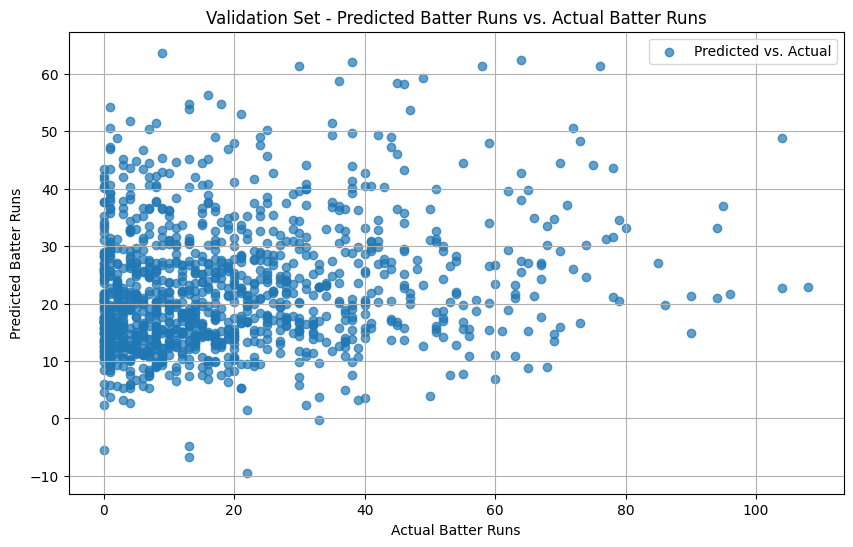

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test['batter_runs'], y_test_br_predictions, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Batter Runs')
plt.ylabel('Predicted Batter Runs')
plt.title('Validation Set - Predicted Batter Runs vs. Actual Batter Runs')
plt.legend()
plt.grid(True)
plt.show()

### StrikeRate

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

target_cols = [ 'strike_rate']


param_grid_xgb = {
    'n_estimators': [80, 100],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
base_estimator = xgb.XGBRegressor()

grid_search_xgb = GridSearchCV(estimator=base_estimator, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train_scaled, y[target_cols])

best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBRegressor:", best_params_xgb)
model = grid_search_xgb.best_estimator_




from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np


# Lists to store results for each fold
iteration_results = {col: [] for col in target_cols}

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])


    # Predict on validation set
    y_pred = model.predict(X_valid_scaled)
    mse = mean_squared_error(y_valid[col], y_pred)
    iteration_results.append(mse)

# Calculate mean and standard deviation for each output
mean_mse = np.mean(iteration_results)
std_mse = np.std(iteration_results)
print(f"{col}:")
print(f"  Mean MSE: {mean_mse:.4f}")
print(f"  Std Dev MSE: {std_mse:.4f}")
print()
  

  

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for XGBRegressor: {'estimator__colsample_bytree': 0.9, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 5, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Processing iteration 1/10
Processing iteration 2/10
Processing iteration 3/10
Processing iteration 4/10
Processing iteration 5/10
Processing iteration 6/10
Processing iteration 7/10
Processing iteration 8/10
Processing iteration 9/10
Processing iteration 10/10
strike_rate:
  Mean MSE: 3923.9497
  Std Dev MSE: 347.8436



### Final Team Total

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

target_cols = ['final_team_total']




param_grid_xgb = {
    'n_estimators': [80, 100],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


  # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
base_estimator = xgb.XGBRegressor()

grid_search_xgb = GridSearchCV(estimator=base_estimator, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train_scaled, y[target_cols])

best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBRegressor:", best_params_xgb)
model = grid_search_xgb.best_estimator_




from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np


# Lists to store results for each fold
iteration_results = []

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    y_pred = model.predict(X_valid_scaled)
    mse = mean_squared_error(y_valid[col], y_pred)
    iteration_results.append(mse)

# Calculate mean and standard deviation for each output
mean_mse = np.mean(iteration_results)
std_mse = np.std(iteration_results)
print(f"{col}:")
print(f"  Mean MSE: {mean_mse:.4f}")
print(f"  Std Dev MSE: {std_mse:.4f}")
print()
  

  

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for XGBRegressor: {'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}
Processing iteration 1/10
Processing iteration 2/10
Processing iteration 3/10
Processing iteration 4/10
Processing iteration 5/10
Processing iteration 6/10
Processing iteration 7/10
Processing iteration 8/10
Processing iteration 9/10
Processing iteration 10/10
net_run_rate:
  Mean MSE: 24644.6114
  Std Dev MSE: 220.6487



### NRR


In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

target_cols = [ 'net_run_rate']




param_grid_xgb = {
    'n_estimators': [80, 100],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


  # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)

    # Create and train the MultiOutputRegressor with XGBoostRegressor
base_estimator = xgb.XGBRegressor()

grid_search_xgb = GridSearchCV(estimator=base_estimator, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train_scaled, y[target_cols])

best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBRegressor:", best_params_xgb)
model = grid_search_xgb.best_estimator_




from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np


# Lists to store results for each fold
iteration_results = []

for iteration_idx, (X_train, X_valid, y_train, y_valid) in enumerate(iterations):
    print(f"Processing iteration {iteration_idx + 1}/{len(iterations)}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Fit the model
    model.fit(X_train_scaled, y_train[target_cols])

    # Predict on validation set
    y_pred = model.predict(X_valid_scaled)

    mse = mean_squared_error(y_valid[col], y_pred)
    iteration_results.append(mse)

# Calculate mean and standard deviation for each output
mean_mse = np.mean(iteration_results)
std_mse = np.std(iteration_results)
print(f"{col}:")
print(f"  Mean MSE: {mean_mse:.4f}")
print(f"  Std Dev MSE: {std_mse:.4f}")
print()
  

  

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for XGBRegressor: {'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}
Processing iteration 1/10
Processing iteration 2/10
Processing iteration 3/10
Processing iteration 4/10
Processing iteration 5/10
Processing iteration 6/10
Processing iteration 7/10
Processing iteration 8/10
Processing iteration 9/10
Processing iteration 10/10
net_run_rate:
  Mean MSE: 1.7536
  Std Dev MSE: 0.1319

